# COMP90051 Workshop 10
## Principal Component Analysis
***
In this worksheet we explore several aspects of Principal Component Analysis (PCA).
1. We implement PCA using singular value decomposition (SVD)
2. We apply PCA to visualise high-dimensional data in 3D
3. We interpret PCA as a data compression algorithm

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # enables 3D plotting

from sklearn.datasets import make_low_rank_matrix
from sklearn.decomposition import PCA

### 1. PCA using SVD

Let's begin by generating some synthetic data to demonstrate PCA.
We'll work in 3D so that we can visualise the data, and later on, the principal components.

In [2]:
X = make_low_rank_matrix(n_features=3, effective_rank=1, n_samples=500, tail_strength=10, random_state=1)

The code block below demonstrates the 3D plotting functionality in `matplotlib`.
You can use the left mouse button to rotate the axes, and the right mouse button to zoom.

*Note: we must explicitly initialise a figure object to start a new plot when using the interactive plotting library.*

<IPython.core.display.Javascript object>


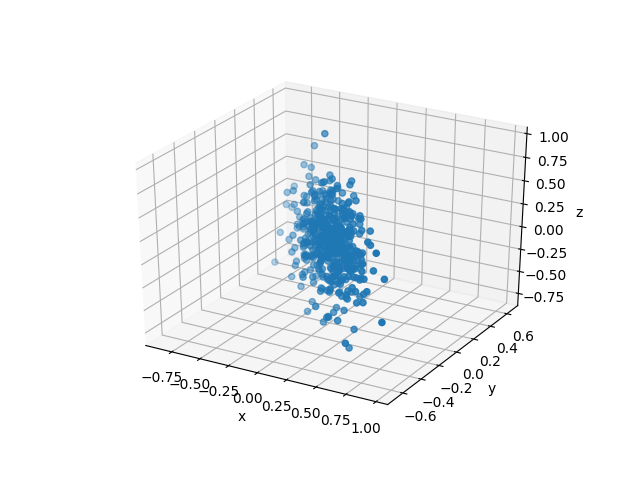

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

**Question:** Is there a direction along which the data has lower variance? You'll likely need to rotate the figure to answer this question.

Let's now apply PCA.

#### Step A: Centring the features
To ensure the first principal component describes the direction of maxmimum variance, the data matrix $\mathbf{X} \in \mathbb{R}^{n \times m}$ must be centred. 
In other words, each column should have zero mean.
Complete the code block below, storing the centred data matrix in `X_centered`.

In [4]:
X_centered = X - np.mean(X, axis=0) # fill in

#### Step B: Solving the eigensystem
In lectures, it was shown that the principal components $\{\mathbf{p}_1, \ldots, \mathbf{p}_m\}$ of $\mathbf{X}$ are the eigenvectors of the data covariance matrix 
$$
\mathbf{\Sigma} = \frac{1}{n - 1} \sum_{i = 1}^{n} \mathbf{x}_i^\intercal \mathbf{x}_i = \frac{1}{n - 1} \mathbf{X}^\intercal \mathbf{X}
$$
(assuming $\mathbf{X}$ is centred).
The eigenvalues $\lambda_i$ may be interpreted as the variance explained by component $\mathbf{p}_i$.

We can obtain the eigenvalues/eigenvectors of $\mathbf{\Sigma}$ using the singular value decomposition (SVD) of $\mathbf{X}$.
Specifically, we write $\mathbf{X}$ as $\mathbf{U} \mathbf{S} \mathbf{V}^\intercal$, where
* $\mathbf{S}$ is a $n \times m$ rectangular diagonal matrix containing the singular values of $\mathbf{X}$
* $\mathbf{U}$ is an $n \times n$ unitary matrix whose columns are the left singular vectors of $\mathbf{X}$
* $\mathbf{V}$ is a $m \times m$ unitary matrix whose columns are the right singular vectors of $\mathbf{X}$

Then, observing that $\mathbf{\Sigma} = \frac{1}{n-1} \mathbf{V} \mathbf{S}^\intercal \mathbf{S} \mathbf{V}^\intercal$ we have:
* the eigenvalues of $\mathbf{\Sigma}$ are the *squared* singular values of $\mathbf{X}$, scaled by $\frac{1}{n-1}$
* the eigenvectors of $\mathbf{\Sigma}$ are the columns of $\mathbf{V}$.

Use this information to compute 
$$
\texttt{eVecs} = \begin{bmatrix}
\mathbf{p}_1 \\
\mathbf{p}_2 \\
\vdots \\
\mathbf{p}_m
\end{bmatrix} \ \text{ and } 
\texttt{eVals} = \begin{bmatrix}
\lambda_1, \lambda_2, \cdots, \lambda_m
\end{bmatrix}
$$
in the code block below. 
*(Hint: use the `numpy.linalg.svd` function.)*

In [5]:
# fill in below
_, S, Vt = np.linalg.svd(X_centered)
eVals = S**2/(X_centered.shape[0] - 1)
eVecs = Vt

for eVal, eVec in zip(eVals, eVecs):
    print('Eigenvalue {:.3g} with eigenvector {}'.format(eVal, eVec))

Eigenvalue 0.129 with eigenvector [-0.8244409   0.56089537 -0.07545588]
Eigenvalue 0.0656 with eigenvector [0.02699606 0.17214996 0.98470077]
Eigenvalue 0.002 with eigenvector [ 0.56530383  0.80979058 -0.15706943]


Now that we've computed the principal components, let's plot them along with the data.
The `quiver` plotting function allows us to plot arrows in 3D.
We must specify the origins of the arrows (`x`, `y`, `z` below) and the end points of the arrows (`dx`, `dy`, `dz` below).
Note: we also rescale the eigenvectors so they're roughly the same scale as the data.

<IPython.core.display.Javascript object>


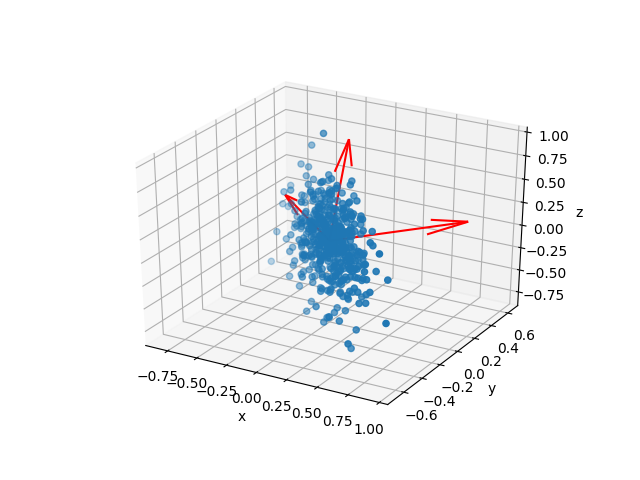

In [6]:
x, y, z = np.zeros_like(eVecs)
dx, dy, dz = eVecs.T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_centered[:,0], X_centered[:,1], X_centered[:,2])
ax.quiver(x, y, z, dx, dy, dz, colors='r')
ax.axis('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

Suppose we decide to represent the data using only the first and second principal components $\mathbf{p}_1$ and $\mathbf{p}_2$.
We can project the data onto the space spanned by $\mathbf{p}_1, \mathbf{p}_2$ as follows:
$$
\mathbf{X}_{\mathrm{pca}} = \mathbf{X} \begin{bmatrix}
    \mathbf{p}_1^\intercal, \mathbf{p}_2^\intercal
\end{bmatrix}
$$

Use this to equation to compute `X_pca` below.

<IPython.core.display.Javascript object>


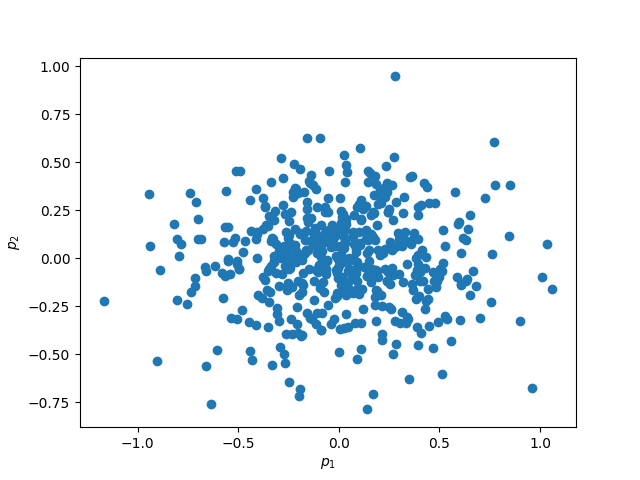

In [7]:
X_pca = X_centered @ eVecs[0:2].T # fill in

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_pca[:,0], X_pca[:,1])
plt.xlabel('$p_1$')
plt.ylabel('$p_2$')
plt.show()

**Exercise:** Apply the inverse transform to map `X_pca` back to the original 3D space and plot the data alongside `X`.

### 2. PCA for visualisation

Let's now apply PCA to a real data set with many features.
We'll use the `digits` data set available in scikit-learn.
It contains 1797 8×8 grayscale images of digits (0-9), along with their labels.

In [8]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
Y = digits.target

Below we plot a random subset of the images.

<IPython.core.display.Javascript object>


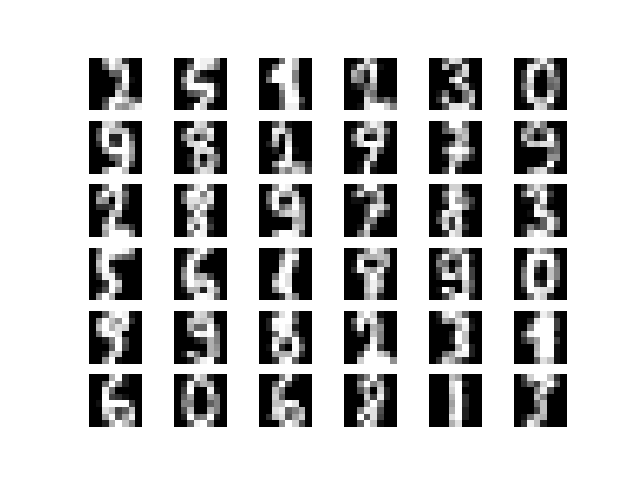

In [9]:
columns = 6
rows = 6
image_ids = np.random.choice(X.shape[0], size = rows*columns, replace=False)
fig = plt.figure()
for i,image_id in enumerate(image_ids):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.imshow(X[image_id].reshape(8,-1), cmap='gray')
    ax.axis('off')
plt.show()

We can apply PCA to visualise the data in 3D.
Notice that the instances are clustered according to the digit (as represented by the colour).

<IPython.core.display.Javascript object>


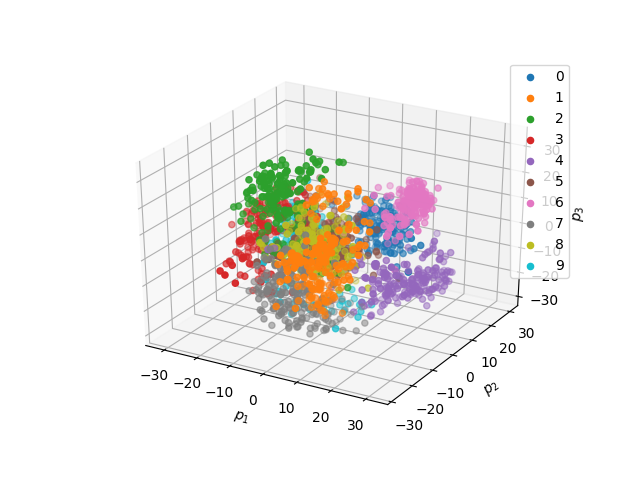

In [10]:
digits_pca = PCA(n_components=3).fit(X)
X_pca = digits_pca.transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for digit in range(10):
    ax.scatter(X_pca[Y==digit,0], X_pca[Y==digit,1], X_pca[Y==digit,2], label=digit)
ax.set_xlabel('$p_1$')
ax.set_ylabel('$p_2$')
ax.set_zlabel('$p_3$')
plt.legend()
plt.show()

**Exercise:** Repeat this visualisation exercise in 2D.

### 3. PCA for data compression
Recall that PCA can be interpeted as finding a set of basis vectors $\{\mathbf{p}_1, \ldots, \mathbf{p}_k\}$ that minimise the residual sum-squared reconstruction error.

Specifically, we can express the original feature vector $\mathbf{x} \in \mathbb{R}^{m}$ in the lower dimensional feature space $\mathbb{R}^k$ as follows:

$$
\mathbf{x}_{\mathrm{pca}} = (\mathbf{x} \cdot \mathbf{p}_1) \mathbf{p}_1 +  \cdots + (\mathbf{x} \cdot \mathbf{p}_k) \mathbf{p}_k = \mathbf{x} \mathbf{W}
$$
where $\mathbf{W} = \begin{bmatrix} \mathbf{p}_1 \\ \vdots \\ \mathbf{p}_k \end{bmatrix}^\intercal$.
The reconstructed feature vector is then $\mathbf{x}_{\mathrm{recon}} = \mathbf{x} \mathbf{W} \mathbf{W}^\intercal$.

Below, we visualise some of the reconstructed images alongside the originals.
Note that `sklearn.decomposition.PCA` has a method for applying the inverse transform $\mathbf{W}^\intercal$.

<IPython.core.display.Javascript object>


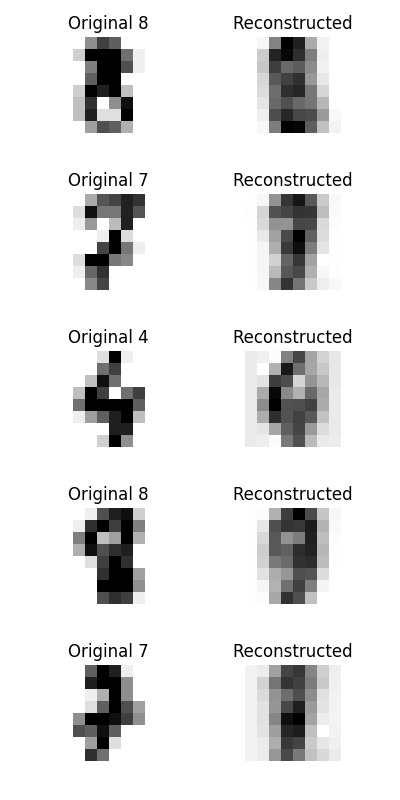

In [11]:
n = 5
image_ids = np.random.choice(X.shape[0], size=n, replace=False)
original = X[image_ids].reshape(n, 8, -1)
labels = Y[image_ids]
reconstructed = digits_pca.inverse_transform(X_pca[image_ids]).reshape(n, 8, -1)

fig = plt.figure(figsize=(4,8))
for i in range(n):
    ax = fig.add_subplot(n, 2, 2*i + 1)
    ax.imshow(original[i], cmap='binary')
    ax.axis('off')
    ax.set_title('Original {}'.format(labels[i]))
    ax = fig.add_subplot(n, 2, 2*i + 2)
    ax.imshow(reconstructed[i], cmap='binary')
    ax.axis('off')
    ax.set_title('Reconstructed')
plt.tight_layout()
plt.show()

**Exercise:** Try compressing the images with a larger number of principal components (> 3).

**Exercise:** Make a Scree plot for the digits data set (proportion of explained variance plotted against number of components).

<IPython.core.display.Javascript object>


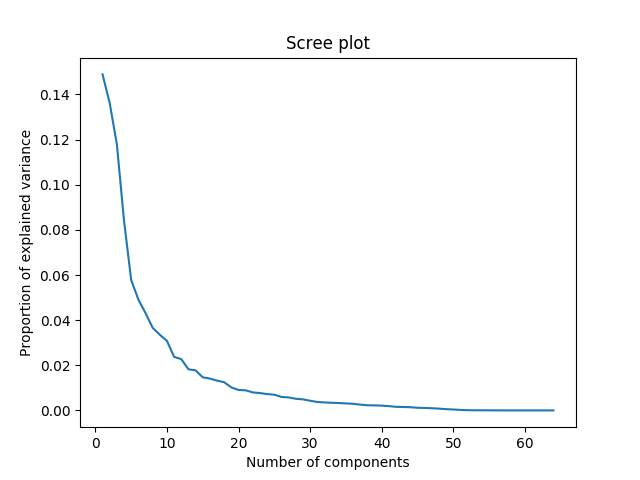

In [12]:
pca = PCA().fit(X)
component_ids = np.arange(pca.components_.shape[0]) + 1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(component_ids, pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Proportion of explained variance')
plt.title('Scree plot')
plt.show()